# SIAMESE NETS

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

from src.features.TripletGenerator import TripletGenerator
from src.features.loss_functions import triplet_loss, identity_loss
from src.models.base_model import base_model, base_model2
from src.models.siamese_model import siamese_model, siamese_model2

In [50]:
from keras.datasets import mnist
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [51]:
from sklearn.datasets import load_iris
data = load_iris()
print(data.keys())
print(data['target_names'])

X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
['setosa' 'versicolor' 'virginica']


((105, 4), (45, 4), (105,), (45,))

In [52]:
with open('../data/processed/pure_data.pkl', 'rb') as data_file:
    df = pickle.load(data_file)
X_train, X_test, y_train, y_test = df

# n_cut = 20
# X_train, X_test, y_train, y_test = X_train[:n_cut], X_test[:n_cut], y_train[:n_cut], y_test[:n_cut]

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2153, 7), (539, 7), (2153,), (539,))

In [65]:
# Define aspects of the model and create instances of both the 
# test and train batch generators and the complete model.

batch_size = 100
LR = 0.001
EPOCHS = 5
alpha = 0.2 

tgen = TripletGenerator()
train_generator = tgen.generate_triplets(X_train, y_train, batch_size)
test_generator = tgen.generate_triplets(X_test, y_test, batch_size)

batch = next(train_generator)

emb_model = base_model2()
model = siamese_model2(emb_model, 1, triplet_loss, identity_loss, learning_rate=LR)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 1, 3)         163         input_25[0][0]                   
                                                                 input_26[0][0]             

In [66]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=20, 
                              verbose=2,
                              steps_per_epoch=20, 
                              validation_steps=30)

Epoch 1/20
20/20 - 3s - loss: 12980.6973 - val_loss: 3000.6387
Epoch 2/20
20/20 - 2s - loss: 7662.9336 - val_loss: 1223.5342
Epoch 3/20
20/20 - 2s - loss: 5412.3306 - val_loss: 370.0333
Epoch 4/20
20/20 - 2s - loss: 4659.0820 - val_loss: 183.2430
Epoch 5/20
20/20 - 2s - loss: 3468.5188 - val_loss: 83.3485
Epoch 6/20
20/20 - 2s - loss: 2894.0767 - val_loss: 46.0647
Epoch 7/20
20/20 - 2s - loss: 2515.9116 - val_loss: 36.0036
Epoch 8/20
20/20 - 2s - loss: 2281.5371 - val_loss: 30.0815
Epoch 9/20
20/20 - 2s - loss: 2297.4287 - val_loss: 36.7547
Epoch 10/20
20/20 - 2s - loss: 1794.7307 - val_loss: 27.8145
Epoch 11/20
20/20 - 2s - loss: 1725.9604 - val_loss: 16.9415
Epoch 12/20
20/20 - 2s - loss: 1363.5206 - val_loss: 15.7035
Epoch 13/20
20/20 - 2s - loss: 1219.9735 - val_loss: 14.7899
Epoch 14/20
20/20 - 2s - loss: 1065.6527 - val_loss: 10.2169
Epoch 15/20
20/20 - 2s - loss: 890.9039 - val_loss: 5.5506
Epoch 16/20
20/20 - 2s - loss: 825.1000 - val_loss: 5.3669
Epoch 17/20
20/20 - 2s - loss:

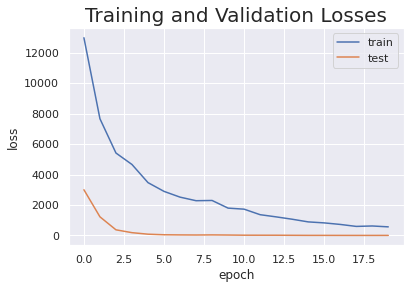

In [67]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [77]:
# Using the newly trained model compute the embeddings 
# for a number images
sample_size = 100
n = 100

# X_train_trm = base_model.predict(X_train[:sample_size].reshape(-1,28,28,1))
# X_test_trm = base_model.predict(X_test[:sample_size].reshape(-1,28,28,1))
X_train_trm = emb_model.predict(X_train[:sample_size].reshape(-1, n, 1))
X_test_trm = emb_model.predict(X_test[:sample_size].reshape(-1, n, 1))

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm[0])


# train_tsne_embeds[:n].shape, y_train[:n].shape
# x = [i[0] for i in train_tsne_embeds[:10]]
# y = [i[1] for i in train_tsne_embeds[:10]]
# plt.scatter(x, y)

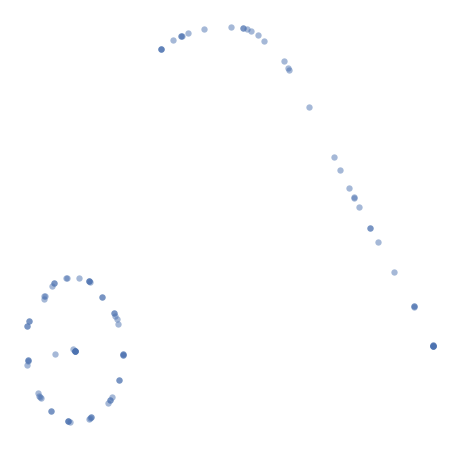

In [79]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 3))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40)#, c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    

scatter(train_tsne_embeds[:n], y_train[:n])


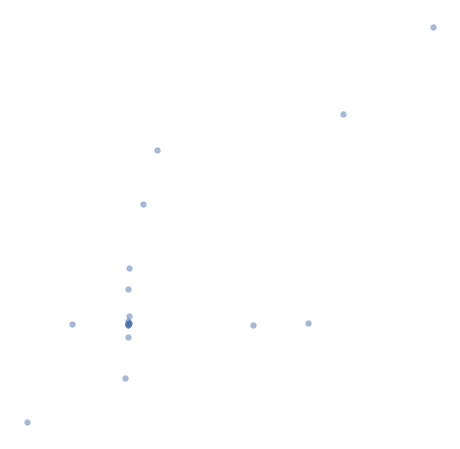

In [80]:
scatter(X_train_trm, y_train[:sample_size])

In [81]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

NameError: name 'Input' is not defined

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])